In [75]:
from typing import List

import pandas as pd
from io import TextIOWrapper
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from dataclasses import dataclass
from random import shuffle, sample, random, randint

In [276]:
@dataclass
class Candidate:
    sites: List[List[int]]

    def calculate_fitness(self, site_schedule: pd.DataFrame, sites: pd.DataFrame) -> float:
        score = 0.0
        for day, i in enumerate(self.sites, start=1):
            current_time = None
            current_location = None
            for site in i:
                current_site = sites[(sites.site == site)].iloc[0]
                current_schedule = site_schedule[(site_schedule.site == site) & (site_schedule.day == day)].iloc[0]

                if current_time is None:
                    current_time = current_schedule['beginhour'] * 60
                else:
                    current_avenue, current_street = current_location
                    current_time += abs(current_avenue - current_site["avenue"]) + abs(current_street - current_site["street"])

                if current_time > 24*60:
                    break
                
                current_location = (current_site["avenue"], current_site["street"])
                if (current_schedule['beginhour'] * 60) > current_time:
                    current_time = (current_schedule['beginhour'] * 60)
                
                if (current_schedule['beginhour'] * 60) <= current_time and (current_time + current_site["desiredtime"]) <= (current_schedule["endhour"] * 60):
                    score += current_site["value"]
                    current_time += current_site["desiredtime"]
                else:
                    current_time = max(current_time, current_schedule["endhour"]*60)
        return score
    
    def mutate(self) -> Candidate:
        roll = random()
        day_roll = random()
        sites = [list(i) for i in self.sites]
        if roll <= 0.5:
            # mutaute a sigle day
            day_sites = sites[randint(0, len(sites) - 1)]
            i, j = sample([i for i in range(len(day_sites))], k=2)
            day_sites[i], day_sites[j] = day_sites[j], day_sites[i]
        else:
            # move site accross days
            origin_i, destination_i = sample([i for i in range(len(sites))], k=2)
            origin_sites = sites[origin_i]
            destination_sites = sites[destination_i] 

            rand_split = randint(0, len(destination_sites) - 1)      
            destination_sites = destination_sites[:rand_split] + [origin_sites.pop(randint(0, len(origin_sites) - 1))] + destination_sites[rand_split:]
        
        return Candidate(sites=sites)


In [277]:
def parse_lines(file: TextIOWrapper, delimeter = " "):
    headers = [i for i in file.readline().rstrip().split(delimeter)]
    data = []
    while True:
        line = file.readline().strip()
        if line == "" or not line:
            break
        data.append([float(i) for i in line.rstrip().split(delimeter)])
    return pd.DataFrame(data=data, columns=headers)


In [278]:
def parse_file(file_name):
    with open(file_name) as f:
        sites = parse_lines(f)
        site_schedules = parse_lines(f)
    return sites, site_schedules

In [286]:
def compute_optimal_path(file_name, population_size=100, max_iter=75):
    sites, site_schedules = parse_file(file_name)

    num_days = int(site_schedules.day.max())

    df_cluster = sites[['avenue', 'street']]
    kmeans = KMeans(num_days)

    clusters = kmeans.fit_predict(sites[['avenue', 'street']].to_numpy())

    initial_days = [[] for i in range(num_days)]

    for i, cluster in enumerate(clusters, start = 1):
        initial_days[cluster].append((i, site_schedules[(site_schedules.site==i) & (site_schedules.day == (cluster+1))].iloc[0].beginhour))

    initial_days = [[i for i,_ in sorted(i, reverse=True, key=lambda x: x[1])] for i in initial_days]

    init_candidate = Candidate(sites=[sample(i, len(i)) for i in initial_days])
    population = [(init_candidate, init_candidate.calculate_fitness(site_schedules, sites))]

    for i in range(population_size - 1):
        candidate = init_candidate.mutate()
        population.append((candidate, candidate.calculate_fitness(site_schedules, sites)))

    for i in range(max_iter):
        population = sorted(population, key=lambda x: x[1], reverse=True)[:int(len(population)/2)]
        
        if i % 100 == 0:
            print(f"iter num: {i}", population[0][1], len(population))

        new_population = []
        for c,score in population:
            new_candidate = c.mutate()
            new_population.append((c, score))
            new_population.append((new_candidate, new_candidate.calculate_fitness(site_schedules, sites)))
        population = new_population
    
    return sorted(population, key=lambda x: x[1], reverse=True)[0]


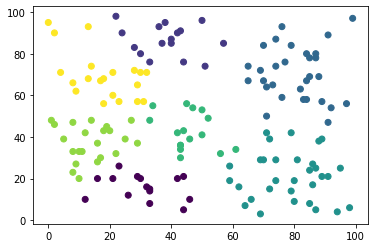

In [215]:
plt.scatter(df_cluster['avenue'], df_cluster['street'], c=clusters)
plt.show()

In [288]:
compute_optimal_path("./examples/example1.txt", population_size=20, max_iter=1000)

iter num: 0 475.7999999999999 10


In [283]:
compute_optimal_path("./examples/example3.txt")

iter num: 0 4723.0 50


(Candidate(sites=[[101, 83, 122, 104, 123, 20, 110, 145, 3, 105, 17, 62, 36, 109, 84, 86, 108, 13, 118, 124, 44, 126, 39, 41, 95, 43], [120, 8, 51, 81, 91, 18, 113, 130, 117, 121, 32, 76, 19, 47, 65, 54, 49, 74], [56, 128, 96, 78, 112, 103, 80, 66, 129, 12, 34, 75, 64, 4, 141, 21, 40, 85, 1], [15, 119, 33, 5, 68, 27, 2, 11, 35, 59, 16, 72, 90, 9, 77, 29, 82, 10, 73, 133], [60, 102, 111, 97, 26, 28, 57, 93, 125, 142, 146, 132, 67], [148, 134, 106, 137, 135, 88, 24, 138, 147, 30, 22, 100, 50, 70, 53, 46, 89, 6, 38, 61, 139, 127, 45, 136, 150, 131, 25, 115], [99, 92, 94, 87, 71, 55, 52, 23, 144, 31, 69, 107, 143, 140, 114, 42, 37, 116, 14]]),
 7583.0)

In [251]:
sites, site_schedules = parse_file("./examples/example1.txt")
Candidate(sites=[[1,99,61,72,64,93],[2,57,71,89,96,37],[4,31,60,94]]).calculate_fitness(site_schedules, sites)

1046.9999999999998